In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

# 1.Load Data

In [2]:
data = np.load("../my_comp_train_XY.npz")
X = data["X"]
y = data["y"]

# 2.Split train, valid and test data

In [3]:
X = X.reshape(X.shape[0], -1)
# split train, valid and test data(ratio 0.6:0.2:0.2)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=10)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=10)

In [4]:
# X_data 0 to 1 scaled
X_train_scaled = X_train / 255.0
X_valid_scaled = X_valid / 255.0
X_test_scaled = X_test / 255.0

In [5]:
print("Train data shape, X_train.shape:{} y_train.shape:{}".format(X_train_scaled.shape, y_train.shape))
print("Valid data shape, X_valid.shape:{} y_valid.shape:{}".format(X_valid_scaled.shape, y_valid.shape))
print("Test data shape, X_test.shape:{} y_test.shape:{}".format(X_test_scaled.shape, y_test.shape))

Train data shape, X_train.shape:(27285, 784) y_train.shape:(27285,)
Valid data shape, X_valid.shape:(9096, 784) y_valid.shape:(9096,)
Test data shape, X_test.shape:(9096, 784) y_test.shape:(9096,)


# 3.Classification

## 3-1.MLP base model

### 3-1-1.Training model

In [6]:
# input layer number of neuron
INPUT_SIZE = 784
# output layer number of neuron
OUTPUT_SIZE = 10
# output layer activation function
OUTPUT_LAYER_ACTIVATION_FUNC = "softmax"
# loss function
LOSS_FUNC = "sparse_categorical_crossentropy"

In [7]:
# Fix epochs and batch size
epochs = 30
batch_size = 32

In [8]:
# validation data
validation_data = (X_valid_scaled, y_valid)

In [9]:
# base model
mlp_clf_base = keras.models.Sequential([
#     keras.layers.Flatten(input_shape=[INPUT_SIZE]), no need (p303)
    keras.layers.Dense(300, activation="relu", input_shape=[INPUT_SIZE]),
    keras.layers.Dense(150, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(70, activation="relu"),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(OUTPUT_SIZE, activation=OUTPUT_LAYER_ACTIVATION_FUNC),
])

In [10]:
mlp_clf_base.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 150)               45150     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               15100     
_________________________________________________________________
dense_3 (Dense)              (None, 70)                7070      
_________________________________________________________________
dense_4 (Dense)              (None, 30)                2130      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                310       
Total params: 305,260
Trainable params: 305,260
Non-trainable params: 0
__________________________________________________

In [11]:
mlp_clf_base.compile(loss=LOSS_FUNC, metrics=["accuracy"], optimizer="Adam")

In [12]:
# early stopping callback
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=10)

In [13]:
# train model and accuracy evaluation with validation data
history = mlp_clf_base.fit(X_train_scaled, y_train, epochs=epochs,
                         batch_size=batch_size,
                         validation_data=validation_data,
                         callbacks=[early_stopping_cb])

Epoch 1/30
853/853 [==============================] - 4s 4ms/step - loss: 0.3490 - accuracy: 0.8910 - val_loss: 0.2126 - val_accuracy: 0.9376
Epoch 2/30
853/853 [==============================] - 3s 4ms/step - loss: 0.1345 - accuracy: 0.9601 - val_loss: 0.1628 - val_accuracy: 0.9506
Epoch 3/30
853/853 [==============================] - 4s 4ms/step - loss: 0.0958 - accuracy: 0.9707 - val_loss: 0.1213 - val_accuracy: 0.9642
Epoch 4/30
853/853 [==============================] - 4s 5ms/step - loss: 0.0723 - accuracy: 0.9777 - val_loss: 0.1149 - val_accuracy: 0.9657
Epoch 5/30
853/853 [==============================] - 5s 6ms/step - loss: 0.0585 - accuracy: 0.9822 - val_loss: 0.1191 - val_accuracy: 0.9689
Epoch 6/30
853/853 [==============================] - 5s 6ms/step - loss: 0.0481 - accuracy: 0.9858 - val_loss: 0.1126 - val_accuracy: 0.9705
Epoch 7/30
853/853 [==============================] - 4s 5ms/step - loss: 0.0380 - accuracy: 0.9885 - val_loss: 0.1137 - val_accuracy: 0.9700
Epoch 

In [14]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [15]:
train_loss, valid_loss = history.history["loss"], history.history["val_loss"]
train_acc, valid_acc = history.history["accuracy"], history.history["val_accuracy"]

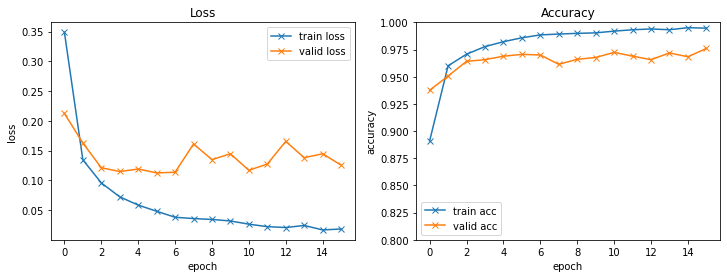

In [16]:
# plot loss and accuracy score with train and valid data along epoch

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(range(len(train_loss)), train_loss, "-x", label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, "-x", label="valid loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.title("Loss")

plt.subplot(122)
plt.plot(range(len(train_acc)), train_acc, "-x", label="train acc")
plt.plot(range(len(valid_acc)), valid_acc, "-x", label="valid acc")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.ylim([0.8, 1.0])
plt.legend()
plt.title("Accuracy")

plt.show()

#### observation

epoch > 4 is over fitting?

### Evaluate model

In [17]:
# evaluate accuracy score with test data
test_score_base = mlp_clf_base.evaluate(X_test_scaled, y_test)
print("Test loss:{}, Test accuracy:{}".format(test_score_base[0], test_score_base[1]))

285/285 [==============================] - 0s 1ms/step - loss: 0.1316 - accuracy: 0.9730
Test loss:0.131563201546669, Test accuracy:0.9729551672935486


In [18]:
# predict with test data
y_pred_test = mlp_clf_base.predict_classes(X_test_scaled)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [19]:
# confusion matrix
matric_mlp_clf_base = confusion_matrix(y_true=y_test, y_pred=y_pred_test)
matric_mlp_clf_base

array([[ 820,    0,    3,    0,    0,    1,    2,    0,    2,    1],
       [   0,  663,    4,    1,    0,    2,    1,    2,    1,    0],
       [   6,    1, 1053,    3,    2,    0,    0,    3,    4,    1],
       [   0,    0,    7,  943,    0,    9,    0,    6,   12,    4],
       [   4,    3,    2,    0,  792,    0,    4,    6,    1,    6],
       [   0,    0,    1,    9,    1,  614,    9,    1,   13,    2],
       [   7,    2,    2,    1,    2,    1, 1050,    0,    0,    0],
       [   1,    4,    9,    1,    1,    0,    0,  981,    0,    6],
       [   2,    9,    4,    3,    4,    0,    3,    3, 1140,    2],
       [   5,    2,    1,    1,   13,    1,    0,   10,    6,  794]],
      dtype=int64)

<AxesSubplot:>

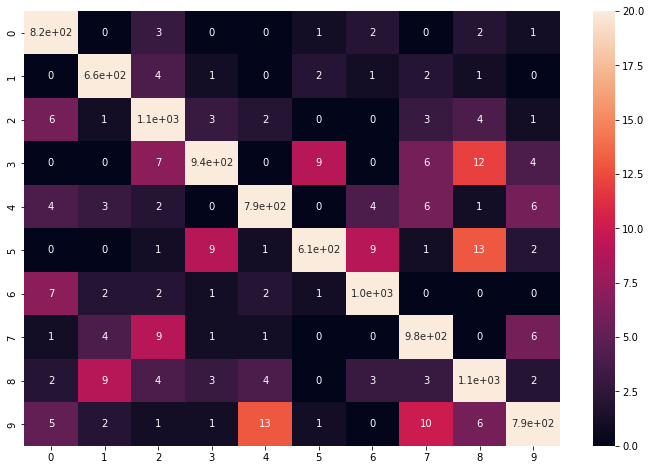

In [20]:
# confusion matrix plot
plt.figure(figsize=(12,8))
sns.heatmap(matric_mlp_clf_base, annot=True, vmin=0, vmax=20)

## 3-2.MLP (tuning learning rate)

### 3-2-1 search best learning rate 

In [21]:
def build_model_tune_hyper_param(input_layers, hidden_layers, optimizer):
    """ Build model with tuning hyper param(hidden_layers, optimizer)"""
    keras.backend.clear_session()
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(input_layers, activation="relu", input_shape=[INPUT_SIZE]))
    for hidden_layer in hidden_layers:
        model.add(keras.layers.Dense(hidden_layer, activation="relu"))
    model.add(keras.layers.Dense(OUTPUT_SIZE, activation=OUTPUT_LAYER_ACTIVATION_FUNC))
    
    model.compile(loss=LOSS_FUNC, metrics=["accuracy"], 
                         optimizer=optimizer)
    return model

In [22]:
def train_model(model, epochs=10, callbacks=None):
    """ Train model """
    history = model.fit(X_train_scaled, y_train, epochs=epochs,
                         batch_size=batch_size,
                         validation_data=validation_data,
                         callbacks=callbacks)
    return history

In [23]:
def build_and_train_model_tune_hyper_param(input_layers, hidden_layers, 
                                             optimizer, epochs=10, callbacks=None):
    """ build and train model """
    model = build_model_tune_hyper_param(input_layers, hidden_layers, optimizer)
    history = train_model(model, epochs=epochs, callbacks=callbacks)
    
    return history, model

In [24]:
# input layers (equal base model)
input_layers = 300
# hidden layers (equal base model)
hidden_layers=[150, 100, 70, 30]
# Hyper params: learning rate
learning_rates = [1e-5, 1e-4, 1e-3, 0.01, 0.1, 1, 10]
# epoch number
epochs = 10

In [25]:
result_tune_lr = []

# train model with changing learning rate(1e-5 < lr < 10)
for learning_rate in learning_rates:
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    history, model = build_and_train_model_tune_hyper_param(input_layers, 
                                             hidden_layers, optimizer, epochs) ## no early stopping
    
    train_loss, val_loss = history.history["loss"], history.history["val_loss"]
    model_summery = {
        "learning_rate": learning_rate,
        "history": history,
        "model": model,
        "train_loss": train_loss,
        "val_loss": val_loss,
    }
    result_tune_lr.append(model_summery)

Epoch 1/10
853/853 [==============================] - 3s 4ms/step - loss: 2.0756 - accuracy: 0.3443 - val_loss: 1.7188 - val_accuracy: 0.5579
Epoch 2/10
853/853 [==============================] - 4s 5ms/step - loss: 1.2895 - accuracy: 0.6682 - val_loss: 0.9376 - val_accuracy: 0.7644
Epoch 3/10
853/853 [==============================] - 4s 5ms/step - loss: 0.7456 - accuracy: 0.8142 - val_loss: 0.6201 - val_accuracy: 0.8425
Epoch 4/10
853/853 [==============================] - 4s 5ms/step - loss: 0.5394 - accuracy: 0.8643 - val_loss: 0.4937 - val_accuracy: 0.8688
Epoch 5/10
853/853 [==============================] - 4s 5ms/step - loss: 0.4440 - accuracy: 0.8841 - val_loss: 0.4261 - val_accuracy: 0.8854
Epoch 6/10
853/853 [==============================] - 4s 5ms/step - loss: 0.3863 - accuracy: 0.8965 - val_loss: 0.3844 - val_accuracy: 0.8940
Epoch 7/10
853/853 [==============================] - 4s 5ms/step - loss: 0.3467 - accuracy: 0.9058 - val_loss: 0.3508 - val_accuracy: 0.9050
Epoch 

853/853 [==============================] - 3s 4ms/step - loss: 2.3894 - accuracy: 0.1147 - val_loss: 2.3368 - val_accuracy: 0.1102
Epoch 9/10
853/853 [==============================] - 3s 3ms/step - loss: 2.3914 - accuracy: 0.1112 - val_loss: 2.5997 - val_accuracy: 0.0741
Epoch 10/10
853/853 [==============================] - 3s 4ms/step - loss: 2.3918 - accuracy: 0.1122 - val_loss: 2.3543 - val_accuracy: 0.1171
Epoch 1/10
853/853 [==============================] - 3s 4ms/step - loss: 203255201792.0000 - accuracy: 0.1058 - val_loss: 2.6032 - val_accuracy: 0.1179
Epoch 2/10
853/853 [==============================] - 3s 4ms/step - loss: 3.2304 - accuracy: 0.1094 - val_loss: 2.8016 - val_accuracy: 0.0916
Epoch 3/10
853/853 [==============================] - 3s 4ms/step - loss: 3.2612 - accuracy: 0.1007 - val_loss: 2.6770 - val_accuracy: 0.1179
Epoch 4/10
853/853 [==============================] - 3s 4ms/step - loss: 3.1334 - accuracy: 0.1072 - val_loss: 2.6927 - val_accuracy: 0.0899
Epoch

Text(0.5, 1.0, 'Valid Loss')

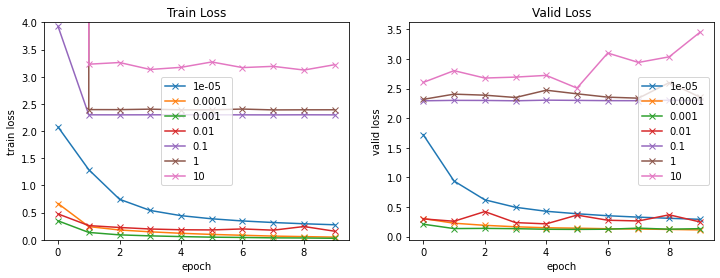

In [26]:
plt.figure(figsize=(12,4))
plt.subplot(121)
for result in result_tune_lr:
    plt.plot(range(0, epochs), result["train_loss"], "-x", label=result["learning_rate"])
plt.ylabel("train loss")
plt.xlabel("epoch")
plt.ylim([0.0, 4.0])
plt.legend()
plt.title("Train Loss")

plt.subplot(122)
for result in result_tune_lr:
    plt.plot(range(0, epochs), result["val_loss"], "-x", label=result["learning_rate"])
plt.ylabel("valid loss")
plt.xlabel("epoch")
plt.legend()
plt.title("Valid Loss")

#### observation

learning rate ～ 1e-3 is better?(equal default value in base model)

In [27]:
# Hyper params: learning rate
learning_rates_2 = [1e-4, 2.5e-4, 5e-4, 7.5e-4, 1e-3, 2.5e-3, 5e-3]
# epoch number
epochs = 20

In [28]:
result_tune_lr_2 = []

# train model with changing learning rate(1e-4 < lr < 5e-3)
for learning_rate in learning_rates:
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    history, model = build_and_train_model_tune_hyper_param(input_layers, 
                                             hidden_layers, optimizer, epochs) ## no early stopping
    
    train_loss, val_loss = history.history["loss"], history.history["val_loss"]
    model_summery = {
        "learning_rate": learning_rate,
        "history": history,
        "model": model,
        "train_loss": train_loss,
        "val_loss": val_loss,
    }
    result_tune_lr_2.append(model_summery)

Epoch 1/20
853/853 [==============================] - 4s 4ms/step - loss: 2.0673 - accuracy: 0.2925 - val_loss: 1.7563 - val_accuracy: 0.5174
Epoch 2/20
853/853 [==============================] - 3s 4ms/step - loss: 1.4199 - accuracy: 0.6653 - val_loss: 1.1304 - val_accuracy: 0.7519
Epoch 3/20
853/853 [==============================] - 3s 4ms/step - loss: 0.9406 - accuracy: 0.7899 - val_loss: 0.7983 - val_accuracy: 0.8094
Epoch 4/20
853/853 [==============================] - 4s 4ms/step - loss: 0.6951 - accuracy: 0.8211 - val_loss: 0.6252 - val_accuracy: 0.8290
Epoch 5/20
853/853 [==============================] - 3s 4ms/step - loss: 0.5556 - accuracy: 0.8493 - val_loss: 0.5181 - val_accuracy: 0.8607
Epoch 6/20
853/853 [==============================] - 4s 4ms/step - loss: 0.4680 - accuracy: 0.8763 - val_loss: 0.4500 - val_accuracy: 0.8798
Epoch 7/20
853/853 [==============================] - 4s 5ms/step - loss: 0.4099 - accuracy: 0.8912 - val_loss: 0.4052 - val_accuracy: 0.8893
Epoch 

853/853 [==============================] - 4s 5ms/step - loss: 0.0127 - accuracy: 0.9966 - val_loss: 0.1714 - val_accuracy: 0.9682
Epoch 19/20
853/853 [==============================] - 4s 4ms/step - loss: 0.0193 - accuracy: 0.9943 - val_loss: 0.1576 - val_accuracy: 0.9697
Epoch 20/20
853/853 [==============================] - 3s 4ms/step - loss: 0.0138 - accuracy: 0.9966 - val_loss: 0.1608 - val_accuracy: 0.9677
Epoch 1/20
853/853 [==============================] - 5s 5ms/step - loss: 0.4597 - accuracy: 0.8691 - val_loss: 0.3120 - val_accuracy: 0.9235
Epoch 2/20
853/853 [==============================] - 4s 4ms/step - loss: 0.2499 - accuracy: 0.9389 - val_loss: 0.2382 - val_accuracy: 0.9474
Epoch 3/20
853/853 [==============================] - 3s 4ms/step - loss: 0.2167 - accuracy: 0.9498 - val_loss: 0.2379 - val_accuracy: 0.9412
Epoch 4/20
853/853 [==============================] - 3s 4ms/step - loss: 0.1948 - accuracy: 0.9533 - val_loss: 0.2174 - val_accuracy: 0.9532
Epoch 5/20
853/

853/853 [==============================] - 3s 3ms/step - loss: 2.3960 - accuracy: 0.1102 - val_loss: 2.3877 - val_accuracy: 0.1102
Epoch 16/20
853/853 [==============================] - 3s 3ms/step - loss: 2.3992 - accuracy: 0.1118 - val_loss: 2.5611 - val_accuracy: 0.1171
Epoch 17/20
853/853 [==============================] - 3s 3ms/step - loss: 2.3912 - accuracy: 0.1133 - val_loss: 2.3248 - val_accuracy: 0.1287
Epoch 18/20
853/853 [==============================] - 3s 3ms/step - loss: 2.3851 - accuracy: 0.1121 - val_loss: 2.4171 - val_accuracy: 0.0911
Epoch 19/20
853/853 [==============================] - 3s 3ms/step - loss: 2.3957 - accuracy: 0.1059 - val_loss: 2.3496 - val_accuracy: 0.1287
Epoch 20/20
853/853 [==============================] - 3s 3ms/step - loss: 2.3912 - accuracy: 0.1127 - val_loss: 2.3832 - val_accuracy: 0.1171
Epoch 1/20
853/853 [==============================] - 3s 3ms/step - loss: 374179561472.0000 - accuracy: 0.1045 - val_loss: 4.6991 - val_accuracy: 0.1171
E

Text(0.5, 1.0, 'Valid Loss')

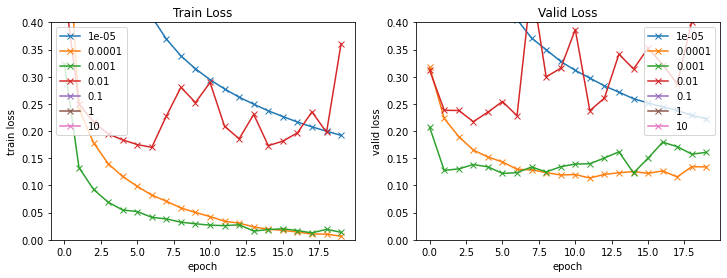

In [29]:
plt.figure(figsize=(12,4))
plt.subplot(121)
for result in result_tune_lr_2:
    plt.plot(range(0, epochs), result["train_loss"], "-x", label=result["learning_rate"])
plt.ylabel("train loss")
plt.xlabel("epoch")
plt.ylim([0.0, 0.4])
plt.legend()
plt.title("Train Loss")

plt.subplot(122)
for result in result_tune_lr_2:
    plt.plot(range(0, epochs), result["val_loss"], "-x", label=result["learning_rate"])
plt.ylabel("valid loss")
plt.xlabel("epoch")
plt.ylim([0.0, 0.4])
plt.legend()
plt.title("Valid Loss")

#### observation

learning rate ～ 7.5e-4 is best?

### 3-2-2 Compare accuracy with best learning rate model and base model

In [30]:
# train model with best learning rate
optimizer = keras.optimizers.Adam(learning_rate=7.5e-4)

history_best_lr, mlp_clf_best_lr = build_and_train_model_tune_hyper_param(
    input_layers, hidden_layers, optimizer=optimizer, 
    epochs=30, callbacks=[early_stopping_cb]) ## with early stopping callback

Epoch 1/30
853/853 [==============================] - 3s 4ms/step - loss: 0.3586 - accuracy: 0.8866 - val_loss: 0.1708 - val_accuracy: 0.9474
Epoch 2/30
853/853 [==============================] - 3s 3ms/step - loss: 0.1319 - accuracy: 0.9616 - val_loss: 0.1532 - val_accuracy: 0.9525
Epoch 3/30
853/853 [==============================] - 3s 4ms/step - loss: 0.0959 - accuracy: 0.9704 - val_loss: 0.1182 - val_accuracy: 0.9630
Epoch 4/30
853/853 [==============================] - 3s 4ms/step - loss: 0.0680 - accuracy: 0.9795 - val_loss: 0.1090 - val_accuracy: 0.9684
Epoch 5/30
853/853 [==============================] - 3s 4ms/step - loss: 0.0515 - accuracy: 0.9849 - val_loss: 0.1086 - val_accuracy: 0.9713
Epoch 6/30
853/853 [==============================] - 3s 4ms/step - loss: 0.0472 - accuracy: 0.9860 - val_loss: 0.1271 - val_accuracy: 0.9677
Epoch 7/30
853/853 [==============================] - 4s 4ms/step - loss: 0.0364 - accuracy: 0.9884 - val_loss: 0.1132 - val_accuracy: 0.9712
Epoch 

In [31]:
# evaluate accuracy score of best learning rate model with test data
test_score_best_lr = mlp_clf_best_lr.evaluate(X_test_scaled, y_test)
print("Test loss:{}, Test accuracy:{}".format(test_score_best_lr[0], test_score_best_lr[1]))

285/285 [==============================] - 0s 2ms/step - loss: 0.1477 - accuracy: 0.9686
Test loss:0.1476801335811615, Test accuracy:0.968557596206665


In [32]:
# predict with test data
y_pred_test_best_lr = mlp_clf_best_lr.predict_classes(X_test_scaled)

# confusion matrix
matric_mlp_clf_best_lr = confusion_matrix(y_true=y_test, y_pred=y_pred_test_best_lr)
matric_mlp_clf_best_lr

array([[ 810,    0,    4,    0,    0,    2,   10,    0,    1,    2],
       [   0,  662,    1,    2,    0,    0,    1,    3,    5,    0],
       [   3,    3, 1022,    9,    4,    0,    3,    5,   22,    2],
       [   0,    1,    3,  929,    0,   18,    0,    5,    8,   17],
       [   0,    2,    2,    0,  781,    0,    2,    6,    2,   23],
       [   0,    0,    0,    9,    1,  621,    8,    0,    4,    7],
       [   2,    1,    1,    0,    3,    5, 1050,    0,    2,    1],
       [   0,    3,    4,    0,    2,    0,    0,  984,    2,    8],
       [   2,    3,    1,    5,    3,    3,    3,    1, 1143,    6],
       [   1,    0,    0,    0,    8,    0,    0,   14,    2,  808]],
      dtype=int64)

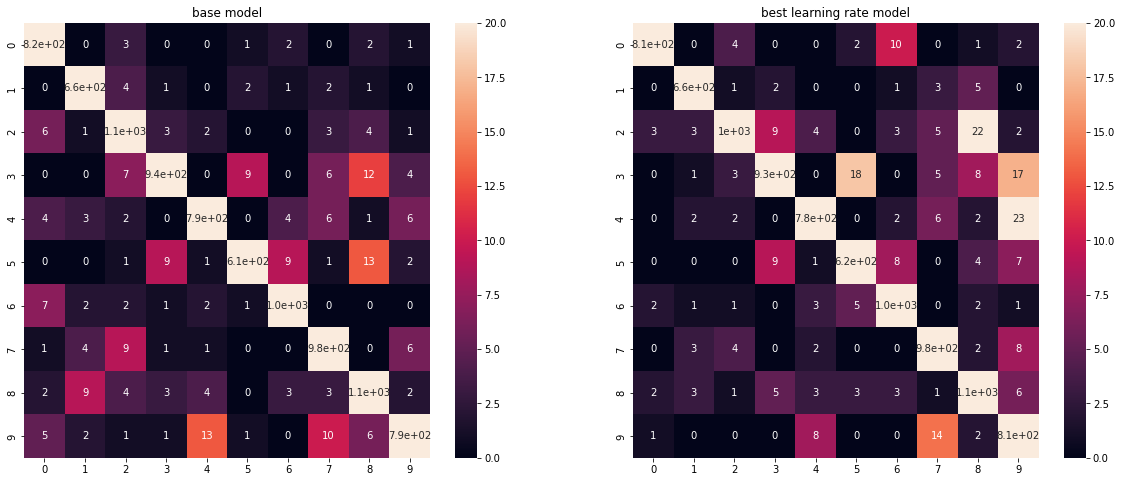

In [33]:
# compare confusion matrix between best learning rate model and base model
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

map_min, map_max = 0, 20
sns.heatmap(matric_mlp_clf_base, annot=True, vmin=map_min, vmax=map_max, ax=axs[0])
sns.heatmap(matric_mlp_clf_best_lr, annot=True, vmin=map_min, vmax=map_max, ax=axs[1])
axs[0].set_title("base model")
axs[1].set_title("best learning rate model")
plt.show()

## 3-3.MLP(tuning hyper param)

### 3-3-1 search best structure of hidden layer and optimizer

In [34]:
# input layers (equal base model)
input_layers = 300
# Hyper params: hidden layers
hidden_layers=[[100, 70, 30],
               [150, 100, 70, 30],
               [350, 230, 150, 100, 70, 30],
               [350, 280, 230, 190, 150, 130, 100, 70, 30]]
# Hyper params: learning rate
learning_rates = [1e-4, 2.5e-4, 5e-4, 7.5e-4, 1e-3, 2.5e-3, 5e-3]
# epoch number
epochs = 30
# early stopping callback
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=10)

In [37]:
# optimizer is sgd (momentum) 
result_tune_hyper_param_sgd = []

for hidden_layer in hidden_layers:
    for learning_rate in learning_rates:
        # Hyper param: optimizer
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate,
                                        momentum=0.9)
        history, model = build_and_train_model_tune_hyper_param(
            input_layers, hidden_layer, optimizer, epochs, callbacks=[early_stopping_cb])

        y_pred_val = model.predict_classes(X_valid_scaled)
        val_acc_end = accuracy_score(y_true=y_valid, y_pred=y_pred_val)
        
        train_loss, val_loss = history.history["loss"], history.history["val_loss"]
        train_acc, val_acc = history.history["accuracy"], history.history["val_accuracy"]
        model_summery = {
            "hidden_layer": hidden_layer,
            "learning_rate": learning_rate,
            "history": history,
            "model": model,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_acc": train_acc,
            "val_acc": val_acc,
            "val_acc_end": val_acc_end,
        }
        result_tune_hyper_param_sgd.append(model_summery)

Epoch 1/30
853/853 [==============================] - 3s 3ms/step - loss: 2.2461 - accuracy: 0.1787 - val_loss: 2.1318 - val_accuracy: 0.3111
Epoch 2/30
853/853 [==============================] - 3s 3ms/step - loss: 1.9630 - accuracy: 0.4170 - val_loss: 1.7634 - val_accuracy: 0.5364
Epoch 3/30
853/853 [==============================] - 3s 4ms/step - loss: 1.5107 - accuracy: 0.6248 - val_loss: 1.2539 - val_accuracy: 0.6837
Epoch 4/30
853/853 [==============================] - 3s 3ms/step - loss: 1.0374 - accuracy: 0.7495 - val_loss: 0.8705 - val_accuracy: 0.7932
Epoch 5/30
853/853 [==============================] - 2s 3ms/step - loss: 0.7493 - accuracy: 0.8205 - val_loss: 0.6675 - val_accuracy: 0.8320
Epoch 6/30
853/853 [==============================] - 3s 3ms/step - loss: 0.5970 - accuracy: 0.8485 - val_loss: 0.5598 - val_accuracy: 0.8529
Epoch 7/30
853/853 [==============================] - 3s 3ms/step - loss: 0.5119 - accuracy: 0.8638 - val_loss: 0.4957 - val_accuracy: 0.8642
Epoch 

853/853 [==============================] - 3s 3ms/step - loss: 0.1111 - accuracy: 0.9694 - val_loss: 0.1575 - val_accuracy: 0.9520
Epoch 29/30
853/853 [==============================] - 3s 3ms/step - loss: 0.1071 - accuracy: 0.9712 - val_loss: 0.1535 - val_accuracy: 0.9540
Epoch 30/30
853/853 [==============================] - 3s 3ms/step - loss: 0.1032 - accuracy: 0.9712 - val_loss: 0.1508 - val_accuracy: 0.9550
Epoch 1/30
853/853 [==============================] - 3s 3ms/step - loss: 1.5887 - accuracy: 0.4753 - val_loss: 0.8170 - val_accuracy: 0.7824
Epoch 2/30
853/853 [==============================] - 3s 3ms/step - loss: 0.5693 - accuracy: 0.8435 - val_loss: 0.4394 - val_accuracy: 0.8740
Epoch 3/30
853/853 [==============================] - 3s 3ms/step - loss: 0.3848 - accuracy: 0.8889 - val_loss: 0.3593 - val_accuracy: 0.8968
Epoch 4/30
853/853 [==============================] - 3s 3ms/step - loss: 0.3189 - accuracy: 0.9078 - val_loss: 0.3101 - val_accuracy: 0.9113
Epoch 5/30
853/

853/853 [==============================] - 4s 5ms/step - loss: 0.0280 - accuracy: 0.9939 - val_loss: 0.1212 - val_accuracy: 0.9653
Epoch 26/30
853/853 [==============================] - 4s 5ms/step - loss: 0.0250 - accuracy: 0.9956 - val_loss: 0.1177 - val_accuracy: 0.9672
Epoch 27/30
853/853 [==============================] - 3s 4ms/step - loss: 0.0230 - accuracy: 0.9958 - val_loss: 0.1229 - val_accuracy: 0.9642
Epoch 28/30
853/853 [==============================] - 3s 3ms/step - loss: 0.0213 - accuracy: 0.9963 - val_loss: 0.1174 - val_accuracy: 0.9659
Epoch 29/30
853/853 [==============================] - 3s 3ms/step - loss: 0.0185 - accuracy: 0.9971 - val_loss: 0.1250 - val_accuracy: 0.9664
Epoch 30/30
853/853 [==============================] - 4s 4ms/step - loss: 0.0168 - accuracy: 0.9974 - val_loss: 0.1268 - val_accuracy: 0.9655
Epoch 1/30
853/853 [==============================] - 3s 4ms/step - loss: 0.9795 - accuracy: 0.7050 - val_loss: 0.3833 - val_accuracy: 0.8969
Epoch 2/30
8

853/853 [==============================] - 4s 5ms/step - loss: 0.1256 - accuracy: 0.9636 - val_loss: 0.1335 - val_accuracy: 0.9588
Epoch 4/30
853/853 [==============================] - 3s 3ms/step - loss: 0.0940 - accuracy: 0.9713 - val_loss: 0.1253 - val_accuracy: 0.9627
Epoch 5/30
853/853 [==============================] - 3s 3ms/step - loss: 0.0663 - accuracy: 0.9804 - val_loss: 0.1414 - val_accuracy: 0.9549
Epoch 6/30
853/853 [==============================] - 3s 3ms/step - loss: 0.0493 - accuracy: 0.9855 - val_loss: 0.1085 - val_accuracy: 0.9687
Epoch 7/30
853/853 [==============================] - 3s 4ms/step - loss: 0.0389 - accuracy: 0.9886 - val_loss: 0.1023 - val_accuracy: 0.9694
Epoch 8/30
853/853 [==============================] - 3s 3ms/step - loss: 0.0291 - accuracy: 0.9914 - val_loss: 0.1241 - val_accuracy: 0.9669
Epoch 9/30
853/853 [==============================] - 3s 3ms/step - loss: 0.0245 - accuracy: 0.9920 - val_loss: 0.1418 - val_accuracy: 0.9626
Epoch 10/30
853/8

853/853 [==============================] - 3s 3ms/step - loss: 0.1873 - accuracy: 0.9456 - val_loss: 0.2166 - val_accuracy: 0.9363
Epoch 14/30
853/853 [==============================] - 3s 3ms/step - loss: 0.1768 - accuracy: 0.9492 - val_loss: 0.2107 - val_accuracy: 0.9381
Epoch 15/30
853/853 [==============================] - 3s 3ms/step - loss: 0.1691 - accuracy: 0.9522 - val_loss: 0.2060 - val_accuracy: 0.9381
Epoch 16/30
853/853 [==============================] - 3s 3ms/step - loss: 0.1606 - accuracy: 0.9529 - val_loss: 0.1992 - val_accuracy: 0.9407
Epoch 17/30
853/853 [==============================] - 3s 3ms/step - loss: 0.1520 - accuracy: 0.9569 - val_loss: 0.1947 - val_accuracy: 0.9422
Epoch 18/30
853/853 [==============================] - 3s 3ms/step - loss: 0.1454 - accuracy: 0.9584 - val_loss: 0.1857 - val_accuracy: 0.9443
Epoch 19/30
853/853 [==============================] - 3s 3ms/step - loss: 0.1395 - accuracy: 0.9597 - val_loss: 0.1808 - val_accuracy: 0.9450
Epoch 20/30

853/853 [==============================] - 3s 3ms/step - loss: 0.1007 - accuracy: 0.9714 - val_loss: 0.1577 - val_accuracy: 0.9521
Epoch 11/30
853/853 [==============================] - 3s 3ms/step - loss: 0.0906 - accuracy: 0.9746 - val_loss: 0.1386 - val_accuracy: 0.9598
Epoch 12/30
853/853 [==============================] - 3s 4ms/step - loss: 0.0799 - accuracy: 0.9779 - val_loss: 0.1435 - val_accuracy: 0.9571
Epoch 13/30
853/853 [==============================] - 3s 4ms/step - loss: 0.0716 - accuracy: 0.9791 - val_loss: 0.1323 - val_accuracy: 0.9621
Epoch 14/30
853/853 [==============================] - 3s 4ms/step - loss: 0.0623 - accuracy: 0.9824 - val_loss: 0.1253 - val_accuracy: 0.9635
Epoch 15/30
853/853 [==============================] - 3s 3ms/step - loss: 0.0556 - accuracy: 0.9844 - val_loss: 0.1278 - val_accuracy: 0.9631
Epoch 16/30
853/853 [==============================] - 3s 3ms/step - loss: 0.0489 - accuracy: 0.9872 - val_loss: 0.1268 - val_accuracy: 0.9641
Epoch 17/30

853/853 [==============================] - 3s 3ms/step - loss: 0.0352 - accuracy: 0.9902 - val_loss: 0.1192 - val_accuracy: 0.9682
Epoch 10/30
853/853 [==============================] - 3s 3ms/step - loss: 0.0262 - accuracy: 0.9926 - val_loss: 0.1258 - val_accuracy: 0.9649
Epoch 11/30
853/853 [==============================] - 3s 3ms/step - loss: 0.0223 - accuracy: 0.9938 - val_loss: 0.1111 - val_accuracy: 0.9705
Epoch 12/30
853/853 [==============================] - 3s 3ms/step - loss: 0.0168 - accuracy: 0.9956 - val_loss: 0.1218 - val_accuracy: 0.9689
Epoch 13/30
853/853 [==============================] - 3s 3ms/step - loss: 0.0114 - accuracy: 0.9974 - val_loss: 0.1186 - val_accuracy: 0.9702
Epoch 14/30
853/853 [==============================] - 3s 3ms/step - loss: 0.0092 - accuracy: 0.9981 - val_loss: 0.1248 - val_accuracy: 0.9712
Epoch 15/30
853/853 [==============================] - 3s 3ms/step - loss: 0.0088 - accuracy: 0.9978 - val_loss: 0.1213 - val_accuracy: 0.9714
Epoch 16/30

853/853 [==============================] - 4s 4ms/step - loss: 0.2144 - accuracy: 0.9389 - val_loss: 0.2488 - val_accuracy: 0.9294
Epoch 24/30
853/853 [==============================] - 4s 4ms/step - loss: 0.2073 - accuracy: 0.9413 - val_loss: 0.2456 - val_accuracy: 0.9289
Epoch 25/30
853/853 [==============================] - 4s 4ms/step - loss: 0.1995 - accuracy: 0.9434 - val_loss: 0.2315 - val_accuracy: 0.9325
Epoch 26/30
853/853 [==============================] - 4s 4ms/step - loss: 0.1923 - accuracy: 0.9455 - val_loss: 0.2292 - val_accuracy: 0.9326
Epoch 27/30
853/853 [==============================] - 4s 5ms/step - loss: 0.1848 - accuracy: 0.9473 - val_loss: 0.2199 - val_accuracy: 0.9358
Epoch 28/30
853/853 [==============================] - 4s 4ms/step - loss: 0.1787 - accuracy: 0.9494 - val_loss: 0.2151 - val_accuracy: 0.9377
Epoch 29/30
853/853 [==============================] - 4s 4ms/step - loss: 0.1733 - accuracy: 0.9505 - val_loss: 0.2107 - val_accuracy: 0.9389
Epoch 30/30

853/853 [==============================] - 4s 5ms/step - loss: 0.0434 - accuracy: 0.9887 - val_loss: 0.1466 - val_accuracy: 0.9599
Epoch 21/30
853/853 [==============================] - 4s 4ms/step - loss: 0.0388 - accuracy: 0.9901 - val_loss: 0.1582 - val_accuracy: 0.9559
Epoch 22/30
853/853 [==============================] - 4s 4ms/step - loss: 0.0360 - accuracy: 0.9908 - val_loss: 0.1447 - val_accuracy: 0.9606
Epoch 23/30
853/853 [==============================] - 4s 4ms/step - loss: 0.0298 - accuracy: 0.9929 - val_loss: 0.1367 - val_accuracy: 0.9634
Epoch 24/30
853/853 [==============================] - 4s 4ms/step - loss: 0.0278 - accuracy: 0.9935 - val_loss: 0.1407 - val_accuracy: 0.9623
Epoch 25/30
853/853 [==============================] - 4s 5ms/step - loss: 0.0231 - accuracy: 0.9947 - val_loss: 0.1400 - val_accuracy: 0.9622
Epoch 26/30
853/853 [==============================] - 4s 5ms/step - loss: 0.0200 - accuracy: 0.9962 - val_loss: 0.1541 - val_accuracy: 0.9613
Epoch 27/30

853/853 [==============================] - 4s 5ms/step - loss: 0.0130 - accuracy: 0.9968 - val_loss: 0.1430 - val_accuracy: 0.9661
Epoch 20/30
853/853 [==============================] - 4s 5ms/step - loss: 0.0069 - accuracy: 0.9988 - val_loss: 0.1436 - val_accuracy: 0.9670
Epoch 21/30
853/853 [==============================] - 4s 5ms/step - loss: 0.0038 - accuracy: 0.9997 - val_loss: 0.1375 - val_accuracy: 0.9687
Epoch 22/30
853/853 [==============================] - 4s 5ms/step - loss: 0.0039 - accuracy: 0.9993 - val_loss: 0.1627 - val_accuracy: 0.9651
Epoch 1/30
853/853 [==============================] - 4s 5ms/step - loss: 0.8862 - accuracy: 0.7034 - val_loss: 0.3261 - val_accuracy: 0.9015
Epoch 2/30
853/853 [==============================] - 4s 5ms/step - loss: 0.2259 - accuracy: 0.9337 - val_loss: 0.1926 - val_accuracy: 0.9439
Epoch 3/30
853/853 [==============================] - 4s 5ms/step - loss: 0.1453 - accuracy: 0.9576 - val_loss: 0.1626 - val_accuracy: 0.9492
Epoch 4/30
853

853/853 [==============================] - 5s 6ms/step - loss: 0.2671 - accuracy: 0.9237 - val_loss: 0.3178 - val_accuracy: 0.9083
Epoch 20/30
853/853 [==============================] - 6s 7ms/step - loss: 0.2542 - accuracy: 0.9277 - val_loss: 0.2925 - val_accuracy: 0.9125
Epoch 21/30
853/853 [==============================] - 7s 8ms/step - loss: 0.2394 - accuracy: 0.9329 - val_loss: 0.2632 - val_accuracy: 0.9228
Epoch 22/30
853/853 [==============================] - 6s 7ms/step - loss: 0.2272 - accuracy: 0.9351 - val_loss: 0.2572 - val_accuracy: 0.9252
Epoch 23/30
853/853 [==============================] - 5s 6ms/step - loss: 0.2161 - accuracy: 0.9382 - val_loss: 0.2564 - val_accuracy: 0.9243
Epoch 24/30
853/853 [==============================] - 5s 6ms/step - loss: 0.2040 - accuracy: 0.9423 - val_loss: 0.2514 - val_accuracy: 0.9263
Epoch 25/30
853/853 [==============================] - 5s 6ms/step - loss: 0.1936 - accuracy: 0.9445 - val_loss: 0.2283 - val_accuracy: 0.9329
Epoch 26/30

853/853 [==============================] - 5s 6ms/step - loss: 0.0466 - accuracy: 0.9870 - val_loss: 0.1476 - val_accuracy: 0.9593
Epoch 17/30
853/853 [==============================] - 6s 7ms/step - loss: 0.0429 - accuracy: 0.9880 - val_loss: 0.1594 - val_accuracy: 0.9581
Epoch 18/30
853/853 [==============================] - 5s 6ms/step - loss: 0.0342 - accuracy: 0.9910 - val_loss: 0.1538 - val_accuracy: 0.9608
Epoch 19/30
853/853 [==============================] - 5s 6ms/step - loss: 0.0305 - accuracy: 0.9925 - val_loss: 0.1466 - val_accuracy: 0.9633
Epoch 20/30
853/853 [==============================] - 5s 6ms/step - loss: 0.0264 - accuracy: 0.9934 - val_loss: 0.1572 - val_accuracy: 0.9609
Epoch 21/30
853/853 [==============================] - 5s 6ms/step - loss: 0.0210 - accuracy: 0.9952 - val_loss: 0.1554 - val_accuracy: 0.9635
Epoch 22/30
853/853 [==============================] - 5s 6ms/step - loss: 0.0186 - accuracy: 0.9956 - val_loss: 0.1582 - val_accuracy: 0.9610
Epoch 23/30

853/853 [==============================] - 5s 6ms/step - loss: 0.0531 - accuracy: 0.9843 - val_loss: 0.1312 - val_accuracy: 0.9643
Epoch 8/30
853/853 [==============================] - 6s 7ms/step - loss: 0.0419 - accuracy: 0.9882 - val_loss: 0.1411 - val_accuracy: 0.9617
Epoch 9/30
853/853 [==============================] - 5s 6ms/step - loss: 0.0328 - accuracy: 0.9904 - val_loss: 0.1455 - val_accuracy: 0.9651
Epoch 10/30
853/853 [==============================] - 6s 7ms/step - loss: 0.0268 - accuracy: 0.9920 - val_loss: 0.1508 - val_accuracy: 0.9632
Epoch 11/30
853/853 [==============================] - 5s 6ms/step - loss: 0.0260 - accuracy: 0.9921 - val_loss: 0.1378 - val_accuracy: 0.9665
Epoch 12/30
853/853 [==============================] - 5s 6ms/step - loss: 0.0186 - accuracy: 0.9941 - val_loss: 0.1424 - val_accuracy: 0.9681
Epoch 13/30
853/853 [==============================] - 5s 6ms/step - loss: 0.0172 - accuracy: 0.9944 - val_loss: 0.1516 - val_accuracy: 0.9632
Epoch 14/30
8

In [ ]:
# optimizer is Adam 
result_tune_hyper_param_adam = []

for hidden_layer in hidden_layers:
    for learning_rate in learning_rates:
        # Hyper param: optimizer
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        history, model = build_and_train_model_tune_hyper_param(
            input_layers, hidden_layer, optimizer, epochs, callbacks=[early_stopping_cb])

        y_pred_val = model.predict_classes(X_valid_scaled)
        val_acc_end = accuracy_score(y_true=y_valid, y_pred=y_pred_val)
        
        train_loss, val_loss = history.history["loss"], history.history["val_loss"]
        train_acc, val_acc = history.history["accuracy"], history.history["val_accuracy"]
        model_summery = {
            "hidden_layer": hidden_layer,
            "learning_rate": learning_rate,
            "history": history,
            "model": model,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_acc": train_acc,
            "val_acc": val_acc,
            "val_acc_end": val_acc_end,
        }
        result_tune_hyper_param_adam.append(model_summery)

Epoch 1/30
853/853 [==============================] - 7s 9ms/step - loss: 0.7948 - accuracy: 0.7661 - val_loss: 0.3206 - val_accuracy: 0.9092
Epoch 2/30
853/853 [==============================] - 6s 7ms/step - loss: 0.2596 - accuracy: 0.9283 - val_loss: 0.2449 - val_accuracy: 0.9278
Epoch 3/30
853/853 [==============================] - 5s 6ms/step - loss: 0.1922 - accuracy: 0.9469 - val_loss: 0.2004 - val_accuracy: 0.9429
Epoch 4/30
853/853 [==============================] - 5s 6ms/step - loss: 0.1542 - accuracy: 0.9566 - val_loss: 0.1770 - val_accuracy: 0.9474
Epoch 5/30
853/853 [==============================] - 5s 6ms/step - loss: 0.1279 - accuracy: 0.9640 - val_loss: 0.1533 - val_accuracy: 0.9538
Epoch 6/30
853/853 [==============================] - 5s 6ms/step - loss: 0.1079 - accuracy: 0.9701 - val_loss: 0.1415 - val_accuracy: 0.9584
Epoch 7/30
853/853 [==============================] - 6s 7ms/step - loss: 0.0906 - accuracy: 0.9746 - val_loss: 0.1312 - val_accuracy: 0.9612
Epoch 

853/853 [==============================] - 6s 7ms/step - loss: 0.0118 - accuracy: 0.9963 - val_loss: 0.1324 - val_accuracy: 0.9733
Epoch 16/30
853/853 [==============================] - 8s 9ms/step - loss: 0.0137 - accuracy: 0.9955 - val_loss: 0.1637 - val_accuracy: 0.9667
Epoch 1/30
853/853 [==============================] - 7s 8ms/step - loss: 0.3501 - accuracy: 0.8980 - val_loss: 0.1839 - val_accuracy: 0.9440
Epoch 2/30
853/853 [==============================] - 7s 8ms/step - loss: 0.1340 - accuracy: 0.9605 - val_loss: 0.1327 - val_accuracy: 0.9601
Epoch 3/30
853/853 [==============================] - 6s 7ms/step - loss: 0.0909 - accuracy: 0.9726 - val_loss: 0.1108 - val_accuracy: 0.9667
Epoch 4/30
853/853 [==============================] - 7s 8ms/step - loss: 0.0666 - accuracy: 0.9790 - val_loss: 0.1024 - val_accuracy: 0.9708
Epoch 5/30
853/853 [==============================] - 6s 7ms/step - loss: 0.0482 - accuracy: 0.9854 - val_loss: 0.1197 - val_accuracy: 0.9646
Epoch 6/30
853/8

In [ ]:
def plot_loss(results, optimizer_name, hidden_layers, ylim_min=None, ylim_max=None):
    plt.figure(figsize=(20, 40))
    for row, hidden_layer in enumerate(hidden_layers):
        result = results[7*row:7*row+6]
        plt.subplot(4, 2, 2*row+1)
        for result0 in result:
            plt.plot(range(len(result0["train_loss"])), result0["train_loss"], "-x", label=result0["learning_rate"])
        plt.ylabel("train loss")
        plt.xlabel("epoch")
        plt.ylim([ylim_min, ylim_max])
        plt.legend()
        plt.title("Train Loss (hidden_layers: {}, optimizer: {})"
                     .format(hidden_layer, optimizer_name))

        plt.subplot(4, 2, 2*row+2)
        for result0 in result:
            plt.plot(range(len(result0["val_loss"])), result0["val_loss"], "-x", label=result0["learning_rate"])
        plt.ylabel("valid loss")
        plt.xlabel("epoch")
        plt.ylim([ylim_min, ylim_max])
        plt.legend()
        plt.title("Valid Loss")

In [ ]:
def plot_acc(results, optimizer_name, hidden_layers, ylim_min=None, ylim_max=None):
    plt.figure(figsize=(20, 40))
    for row, hidden_layer in enumerate(hidden_layers):
        result = results[7*row:7*row+6]
        plt.subplot(4, 2, 2*row+1)
        for result0 in result:
            plt.plot(range(len(result0["train_acc"])), result0["train_acc"], "-x", label=result0["learning_rate"])
        plt.ylabel("train acc")
        plt.xlabel("epoch")
        plt.ylim([ylim_min, ylim_max])
        plt.legend()
        plt.title("Train acc (hidden_layers: {}, optimizer: {})"
                     .format(hidden_layer, optimizer_name))

        plt.subplot(4, 2, 2*row+2)
        for result0 in result:
            plt.plot(range(len(result0["val_acc"])), result0["val_acc"], "-x", label=result0["learning_rate"])
        plt.ylabel("valid acc")
        plt.xlabel("epoch")
        plt.ylim([ylim_min, ylim_max])
        plt.legend()
        plt.title("Valid acc")

In [ ]:
plt.figure(figsize=(20, 8))
plt.subplot(2, 2, 1)
for row in len(hidden_layers):
    result = result_tune_hyper_param_sgd[7*row:7*row+6]
    for result0 in result:
        plt.plot(result0["learning_rate"], result0["val_acc_end"], "-x", label=result0["hidden_layer"])
plt.ylabel("Valid acc endpoint")
plt.xlabel("learning_rate")
plt.ylim([ylim_min, ylim_max])
plt.legend()
plt.title("Valid acc endpoint (optimizer: SGD)")

plt.subplot(2, 2, 2)
for row in len(hidden_layers):
    result = result_tune_hyper_param_adam[7*row:7*row+6]
    for result0 in result:
        plt.plot(result0["learning_rate"], result0["val_acc_end"], "-x", label=result0["hidden_layer"])
plt.ylabel("Valid acc endpoint")
plt.xlabel("learning_rate")
plt.ylim([ylim_min, ylim_max])
plt.legend()
plt.title("Valid acc endpoint (optimizer: Adam)")

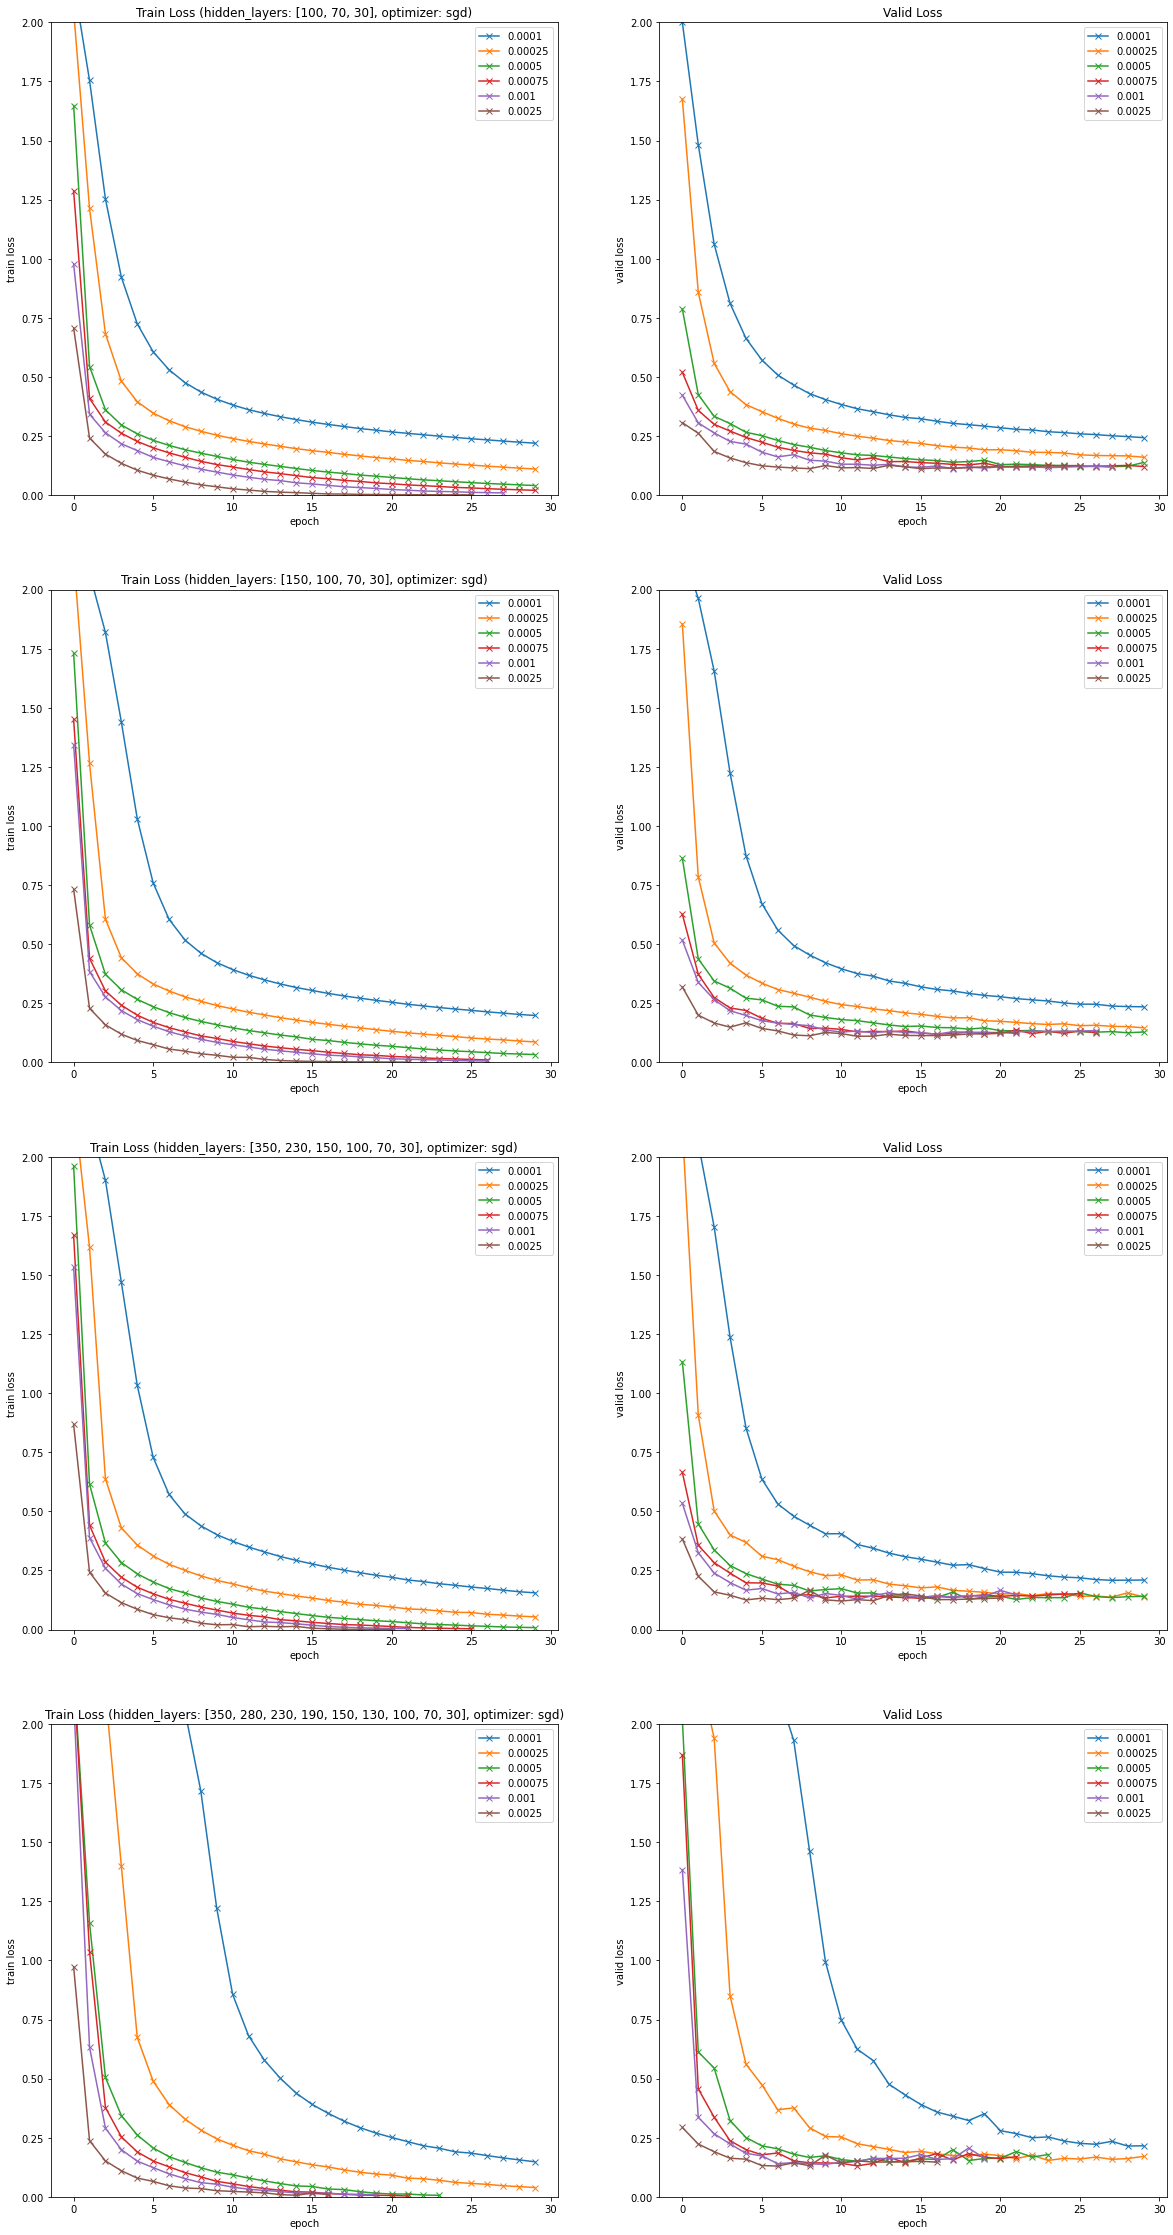

In [115]:
plot_loss(results=result_tune_hyper_param_sgd, optimizer_name="sgd", 
          hidden_layers=hidden_layers, ylim_min=0.0, ylim_max=2.0)

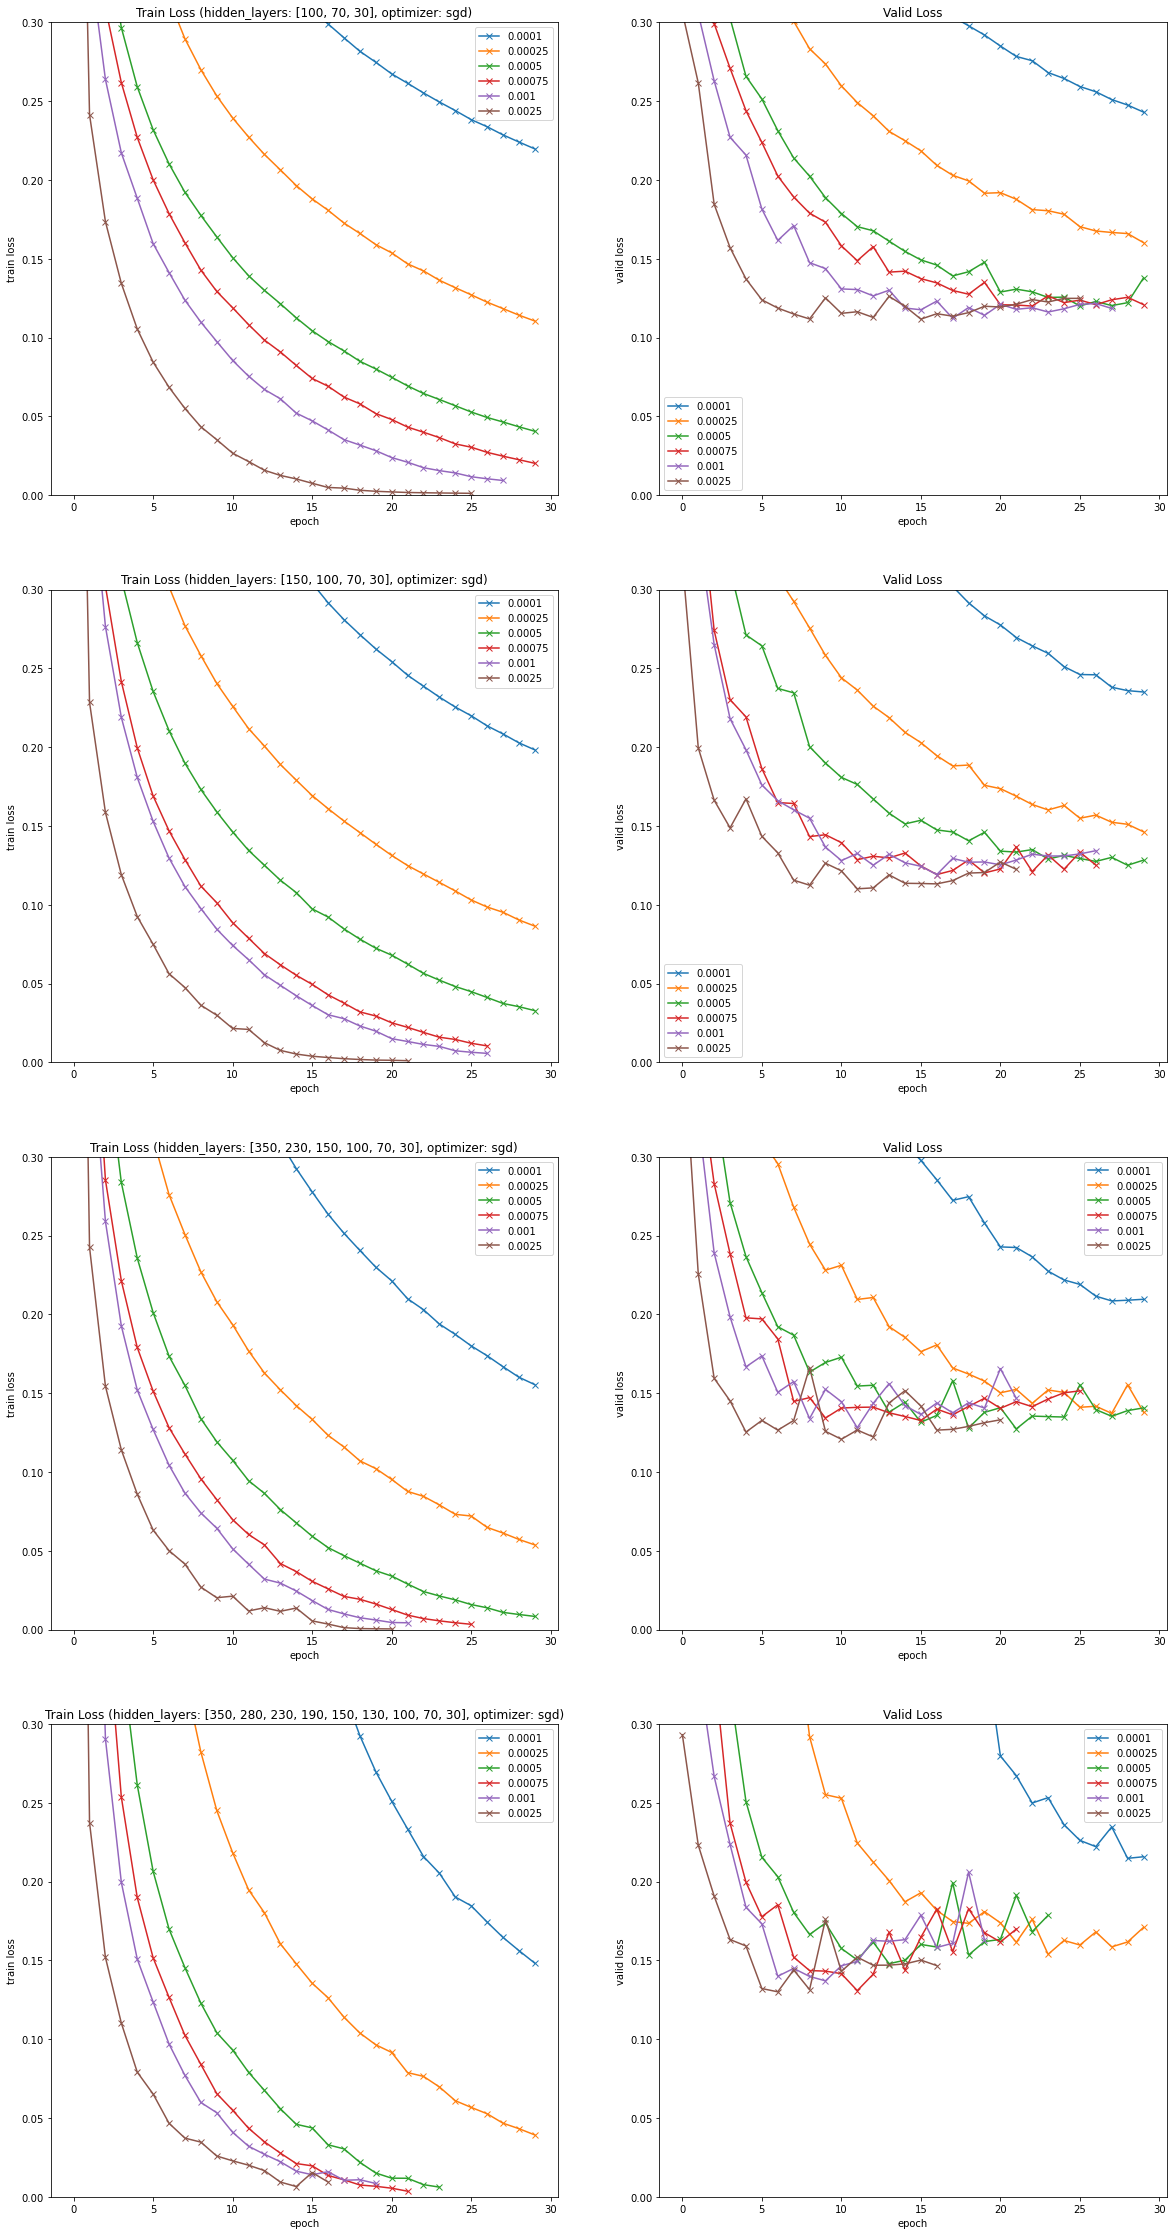

In [116]:
plot_loss(results=result_tune_hyper_param_sgd, optimizer_name="sgd", 
          hidden_layers=hidden_layers, ylim_min=0.0, ylim_max=0.3)

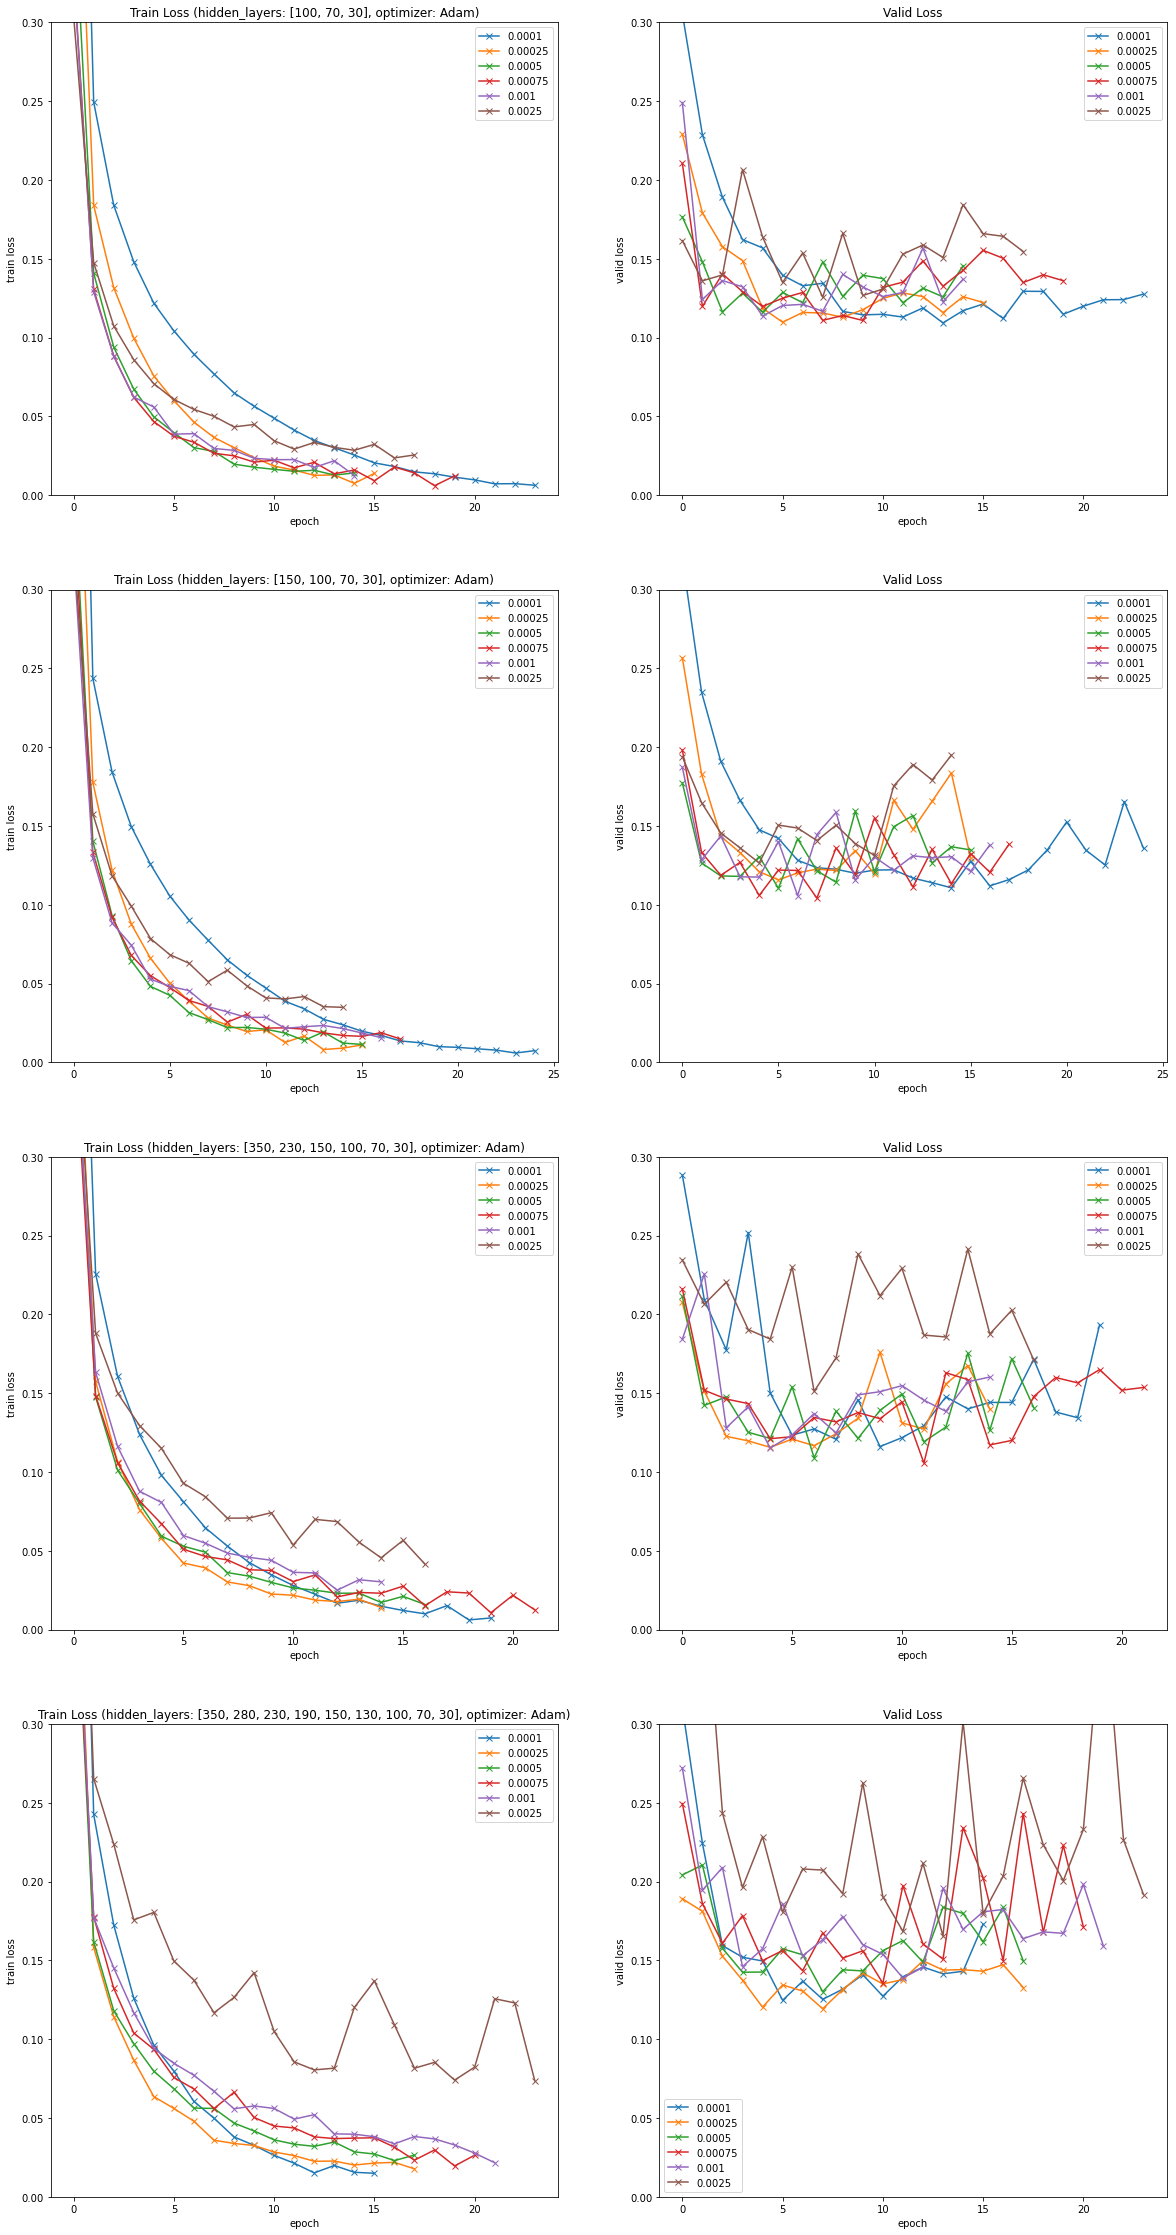

In [117]:
plot_loss(results=result_tune_hyper_param_adam, optimizer_name="Adam", 
          hidden_layers=hidden_layers, ylim_min=0.0, ylim_max=0.3)

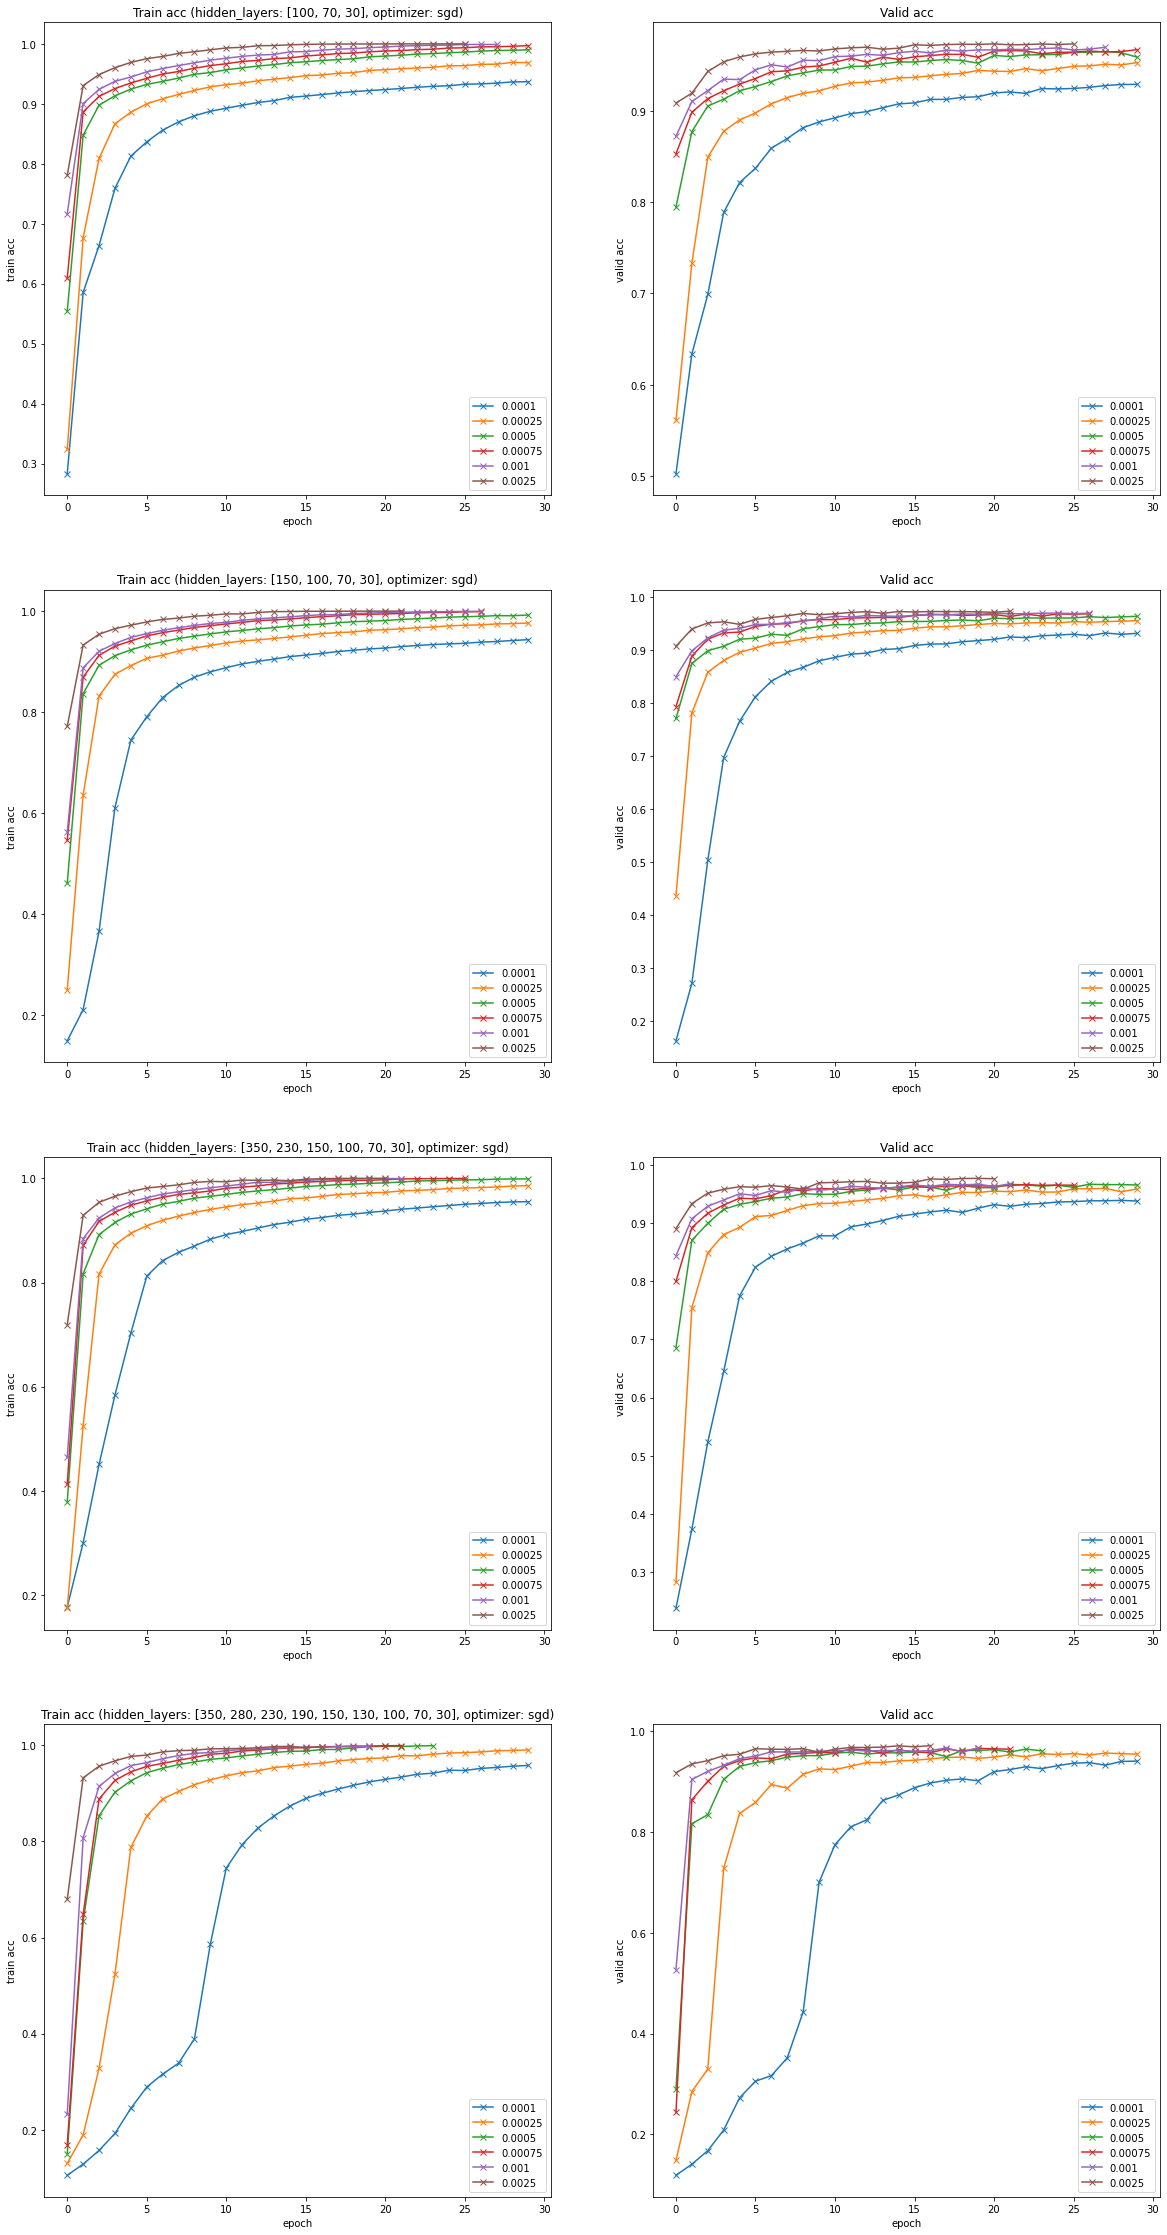

In [120]:
plot_acc(results=result_tune_hyper_param_sgd, optimizer_name="sgd", 
          hidden_layers=hidden_layers)

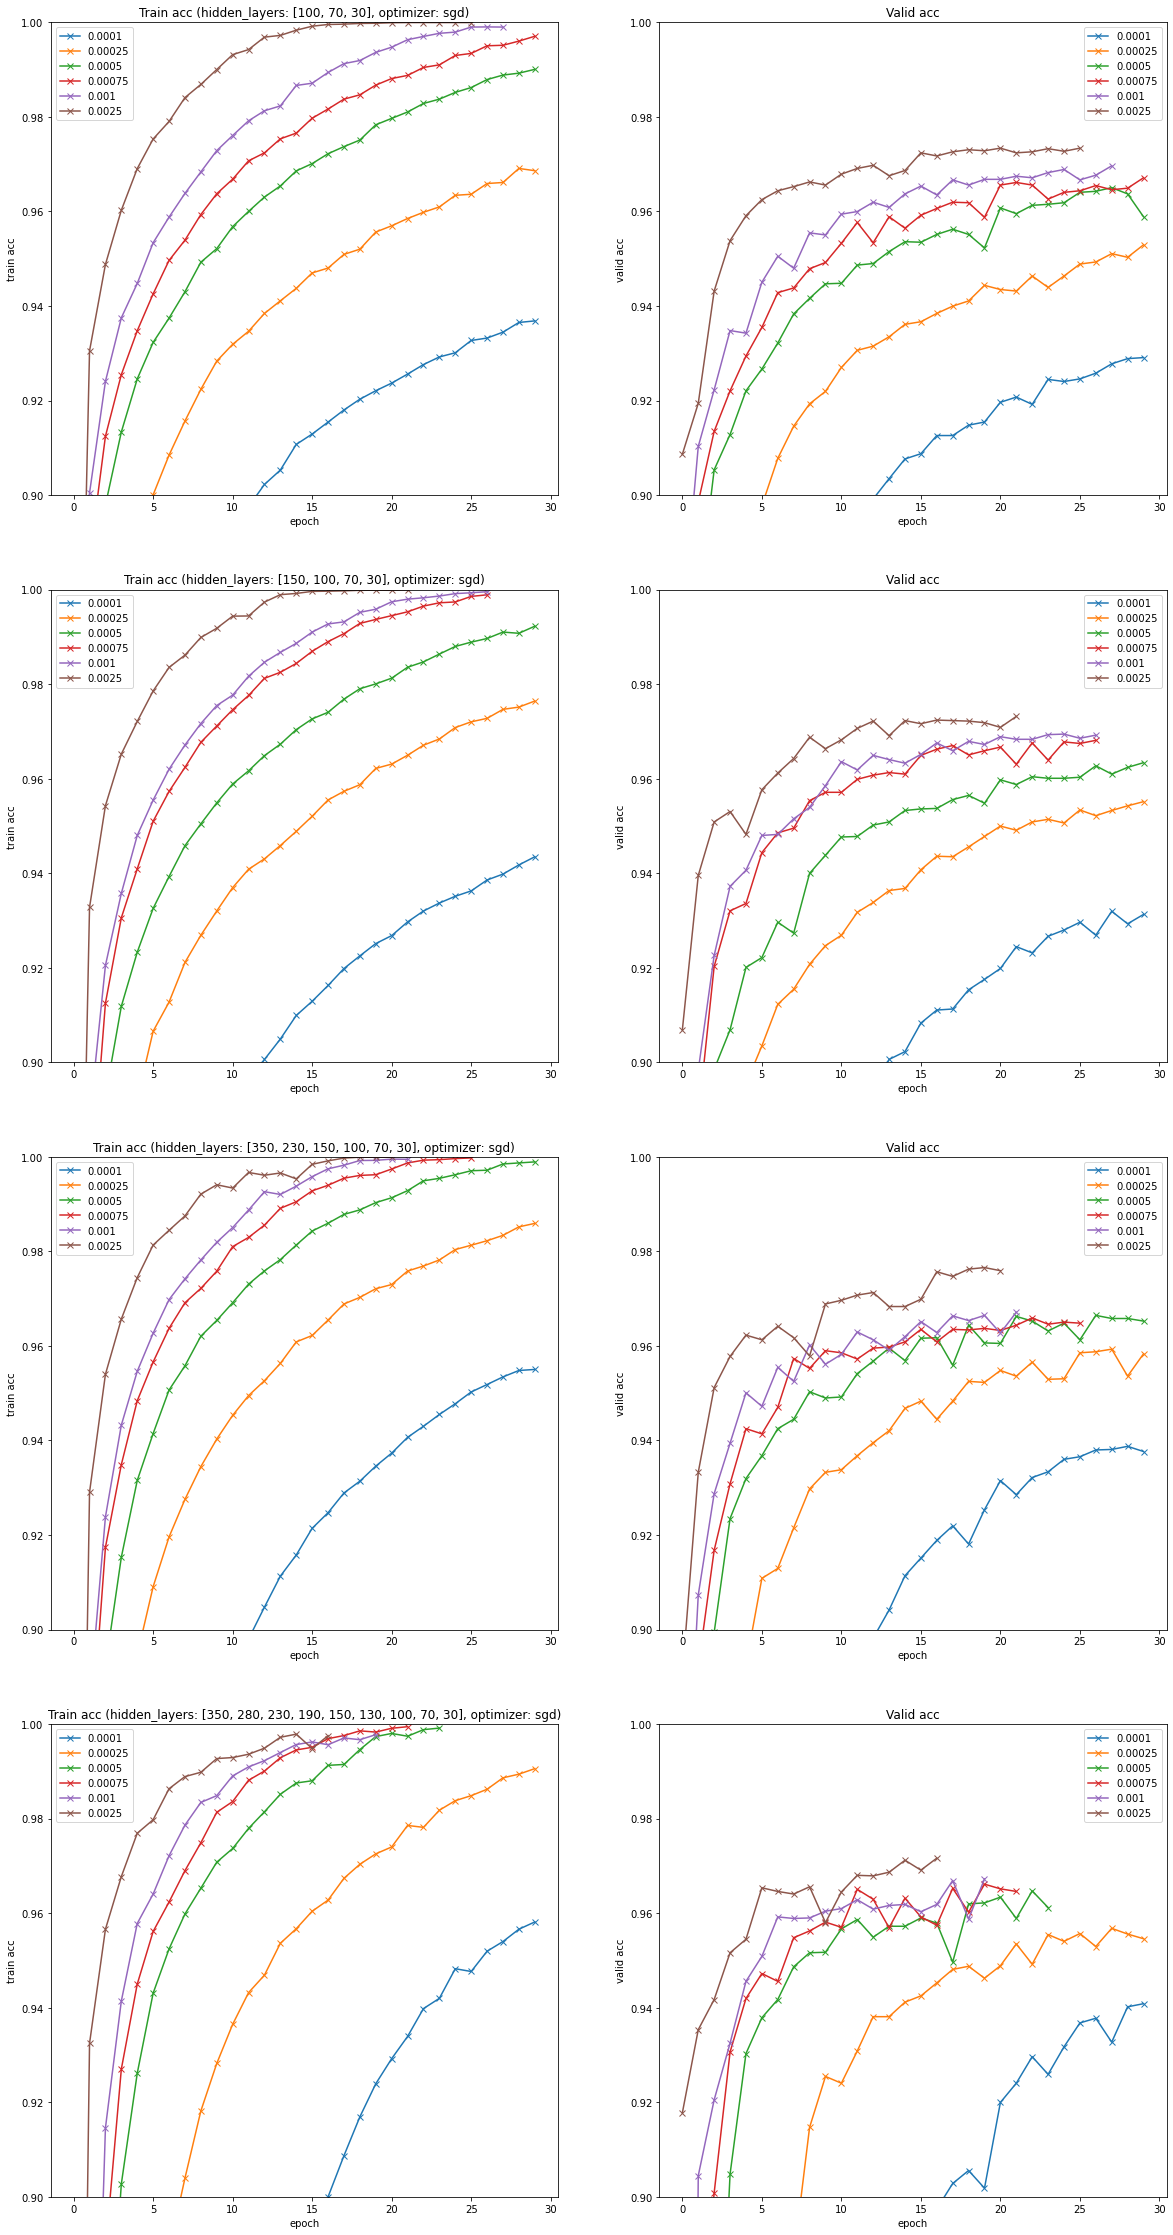

In [123]:
plot_acc(results=result_tune_hyper_param_sgd, optimizer_name="sgd", 
          hidden_layers=hidden_layers, ylim_min=0.9, ylim_max=1.0)

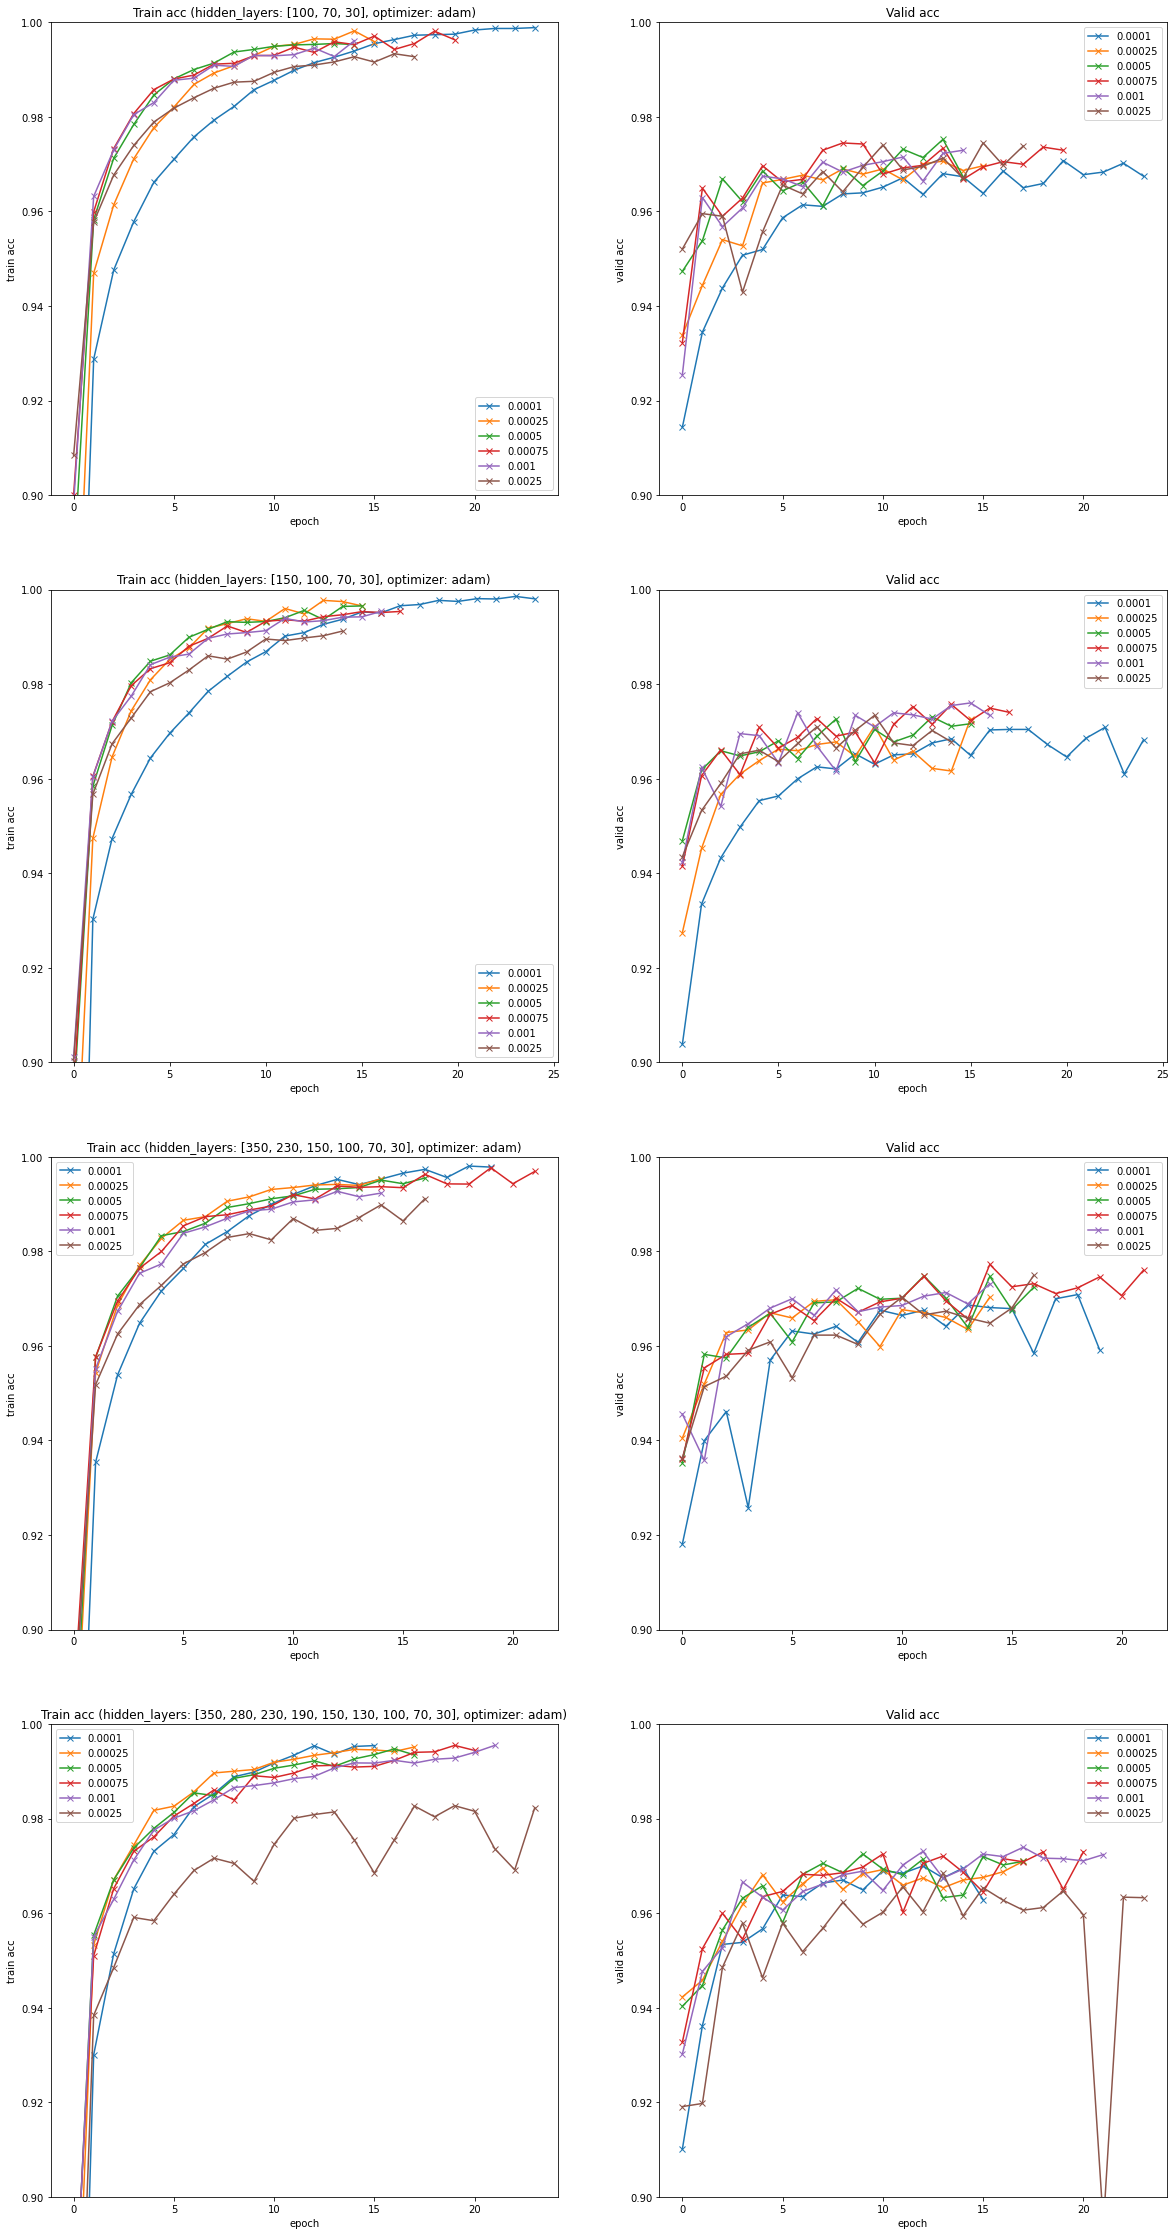

In [122]:
plot_acc(results=result_tune_hyper_param_adam, optimizer_name="adam", 
          hidden_layers=hidden_layers, ylim_min=0.9, ylim_max=1.0)

①SGD

モデルの学習曲線より
(1)hidden layer=[100, 70, 30]
・lr < 0.00075　ではまだ早期打ち切りが働いていない
　→まだエポック数を増やせば、もう少し精度があがるかもしれない

・lr = 0.001　が最適な学習率に見える

(2)hidden_layer=[150, 100, 70, 30]
・lr < 0.0005　ではまだ早期打ち切りが働いていない
・lr = 0.001　が最適な学習率に見える

(3)hidden_layer=[350, 230, 150, 100, 70, 30]
・lr < 0.0005　ではまだ早期打ち切りが働いていない
・lr = 0.001　が最適な学習率に見える

(4)hidden_layer=[350, 280, 230, 190, 150, 130, 100, 70, 30]
・lr < 0.00025　ではまだ早期打ち切りが働いていない
・lr = 0.001 or 0.00075　が最適な学習率に見える

②Adam

モデルの学習曲線より
学習率は下記の通りが最適か？ただ、SGDよりも損失値のブレが大きい…
(1)hidden layer=[100, 70, 30]
・lr = 0.00025　が最適な学習率に見える

(2)hidden_layer=[150, 100, 70, 30]
・lr = 0.00075　が最適な学習率に見える

(3)hidden_layer=[350, 230, 150, 100, 70, 30]
・lr = 0.0005　が最適な学習率に見える

(4)hidden_layer=[350, 280, 230, 190, 150, 130, 100, 70, 30]
・lr = 0.00025　が最適な学習率に見える